# Genetic optimization of an adiabatic annealing schedule

D-Wave limitations: 
1. Limited number of points in a given anneal schedule
3. Maximum slope specified by the machine.

Our Genetic optimization is compared to the basis s = t/t_f linear schedule. The total anneal time is fixed to 100 mus. We create a population of 20 anneal schedules (individuals). Their genome is the ordered list of points where the slope changes in the anneal schedule. In the initial population, we seed in the linear anneal schedule so that it may compare and benefit from mixing with the others. 

We perform the optimization with N_elite = 2. The breeding method is simply done by finding the geometric mean for each gene is the two parents (an example will be shown below). A mutation rate is included in two different ways: 1) where random genes (anneal points) are slightly shifted upwards or downwards by an amount picked from a gaussian with 0 average and a user specified variance, 2) where an interval between two genes is shrunk (careful with the max slope!). 

Hopefully, it takes less total calls to the machine to optain a lowest energy state. Benchmark is done on a randomly obtained spin glass instance. We plot the log(-E_best) vs iterations, in order to see the convergence to a given ground state that may be the solution to an optimization problem.

**Note to do:**
1. Update text and add more info about what you are doing, like a diagram of the genetic algorithm process.

# First the d-wave setup

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import dwave_networkx as dnx
import networkx as nx
%matplotlib inline
import matplotlib as mpl
import math
from dwave.system import DWaveSampler
import minorminer as mm
import dwave.inspector
import matplotlib.cm as cm
import pandas as pd
import json

In [7]:
# Use a D-Wave system as the sampler
f = open("token.txt", "r")
#sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())
sampler = DWaveSampler(solver=dict(topology__type='chimera'),token=f.read())

#print sampler properties
print("---- Sampler properties ----")
print("QPU {} was selected.".format(sampler.solver.name))
print("Chosen topology is:")
print(sampler.properties["topology"])
print("Maximum anneal-schedule points: {}".format(sampler.properties["max_anneal_schedule_points"]))
print("Annealing time range: {} (in us)".format(sampler.properties["annealing_time_range"]))
max_slope = 1.0/sampler.properties["annealing_time_range"][0]
print("Maximum slope allowed on this solver is {:.2f}.".format(max_slope))
print("J range: {}".format(sampler.properties["j_range"]))
print("h range: {}".format(sampler.properties["h_range"]))

---- Sampler properties ----
QPU DW_2000Q_6 was selected.
Chosen topology is:
{'type': 'chimera', 'shape': [16, 16, 4]}
Maximum anneal-schedule points: 12
Annealing time range: [1.0, 2000.0] (in us)
Maximum slope allowed on this solver is 1.00.
J range: [-1.0, 1.0]
h range: [-2.0, 2.0]


12


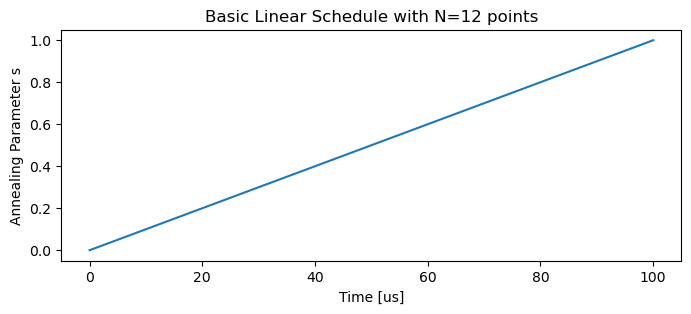

In [8]:
#basic linear anneal schedule (no pause)
max_time = 100
npt = 10 #no. of points is npt+2
#basic_schedule = [[0.0, 0.0], [100, 1.0]]
basic_schedule = []
basic_schedule.append([0.0, 0.0])
for j in range(1,npt+1):
    basic_schedule.append([max_time*(j/(npt+1)),1*(j/(npt+1))])
basic_schedule.append([max_time, 1.0])
print(len(basic_schedule))

#plot it
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Basic Linear Schedule with N={} points".format(npt+2))
ax.plot([basic_schedule[i][0] for i in range(len(basic_schedule))], [basic_schedule[i][1] for i in range(len(basic_schedule))])
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

# Population plotting function

In [9]:
#plot the population
def plot_population(population_into, labels = None):
    plt.figure(figsize=(8, 3))
    ax = plt.gca()
    ax.set_title("Randomized Anneal Schedules with N={} points".format(npt+2))
    for j in range(len(population_into)):
        schedule = population_into[j]
        if labels == None:
            plot_label = 'instance {}'.format(j)
        else:
            plot_label = labels[j]
        ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
    plt.legend()
    plt.xlim([0,max_time])
    plt.xlabel('Time [us]')
    plt.ylabel('Annealing Parameter s')
    plt.show()

# Define a hard random problem instance on the given graph. 

No magnetic fields, but random J_{ij} on all couplers. Then do a benchmark forward anneal to find the ground state (minimum energy state in less time)

In [10]:
#a random problem instance
h = {v: 0.0 for v in sampler.nodelist}
choices_J = [-1, 0.9]
#choices_J = [-1, 0, 1]
J = {tuple(c): np.random.choice(choices_J) for c in sampler.edgelist}

print("Bias 0 assigned to", len(h), "qubits.")
print("Strengths {} assigned randomly to".format(choices_J),len(J),"couplers.")

Bias 0 assigned to 2041 qubits.
Strengths [-1, 0.9] assigned randomly to 5974 couplers.


In [11]:
#a basic forward anneal without optimization
#obtain the results
benchmark_answer = sampler.sample_ising(h, J, 
                                      num_reads=1000, 
                                      anneal_schedule=basic_schedule, 
                                      label='AS - benchmark',
                                      answer_mode='raw')
benchmark_solutions, benchmark_energies = benchmark_answer.record.sample, benchmark_answer.record.energy
#benchmark_solutions, benchmark_energies = forward_solutions, forward_energies
print("QPU time used:", benchmark_answer.info['timing']['qpu_access_time']/10**6, " seconds.")
#last one was 0.5 seconds.

QPU time used: 0.48218090999999996  seconds.


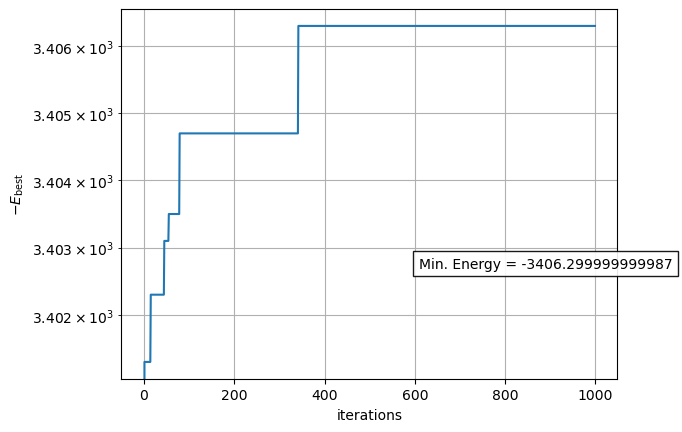

In [12]:
#plot the best result vs iteration:
#extract "fidelity"
nresults = len(benchmark_energies)
fidelity = np.zeros(nresults)
for i in range(1, len(benchmark_energies)):
    fidelity[i] = -np.min(benchmark_energies[:i])

fig, ax = plt.subplots()
ax.plot(fidelity)
ax.set_yscale('log')
ax.set_xlabel('iterations')
ax.set_ylabel(r'$-E_{\rm best}$');
ax.grid(True, which='both')
ax.text(0.6, 0.3, 'Min. Energy = {}'.format(-fidelity[-1]), bbox=dict(facecolor='white', alpha=0.9), transform=ax.transAxes)
plt.show()

Note that, in order to *really* benchmark such problems, we would need to run this code multiple times. Note that, even running it 20 times will require 10 seconds out of the available free minute. Therefore, more time would be needed.

# Functions for the Genetic algorithm

Firstly a function that creates random population instances.
Secondly, a set of functions for
1. Breeding
2. Mutation
3. Fidelity evaluation
4. New population instance

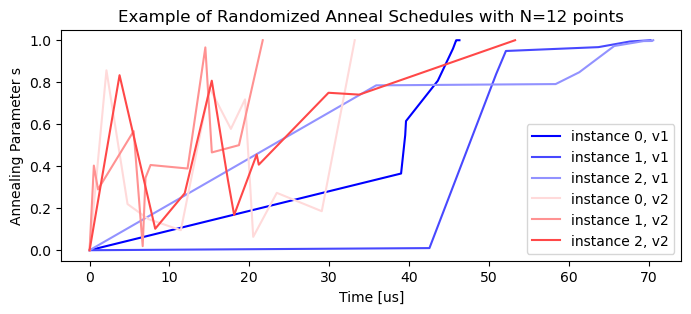

In [17]:
#a random anneal schedule that satisfies the constraints.
def create_random_schedule(npt, version):
    random_anneal_time = np.random.uniform(max_time/10, max_time)
    cond = False
    while cond == False:
        random_schedule = []
        random_schedule.append([0.0, 0.0])
        index_schedule = 0
        for j in range(npt):
            if version == 'v1':
                #v1
                rand_t = np.random.uniform(random_schedule[index_schedule][0], random_anneal_time)
                delta_t = rand_t - random_schedule[index_schedule][0]
                rand_s = np.random.uniform(random_schedule[index_schedule][1], np.min([1.0, random_schedule[index_schedule][1] + max_slope*delta_t]))
            elif version == 'v2':
                #v2
                rand_t = np.random.uniform(random_schedule[index_schedule][0], (j+1)*random_anneal_time/(npt+1))
                delta_t = rand_t - random_schedule[index_schedule][0]
                rand_s = np.random.uniform(random_schedule[index_schedule][1], np.min([(j+1)/(npt+1), random_schedule[index_schedule][1] + max_slope*delta_t]))
            elif version == 'v3':
                #v3
                rand_t = np.random.uniform(random_schedule[index_schedule][0], (j+1)*random_anneal_time/(npt+1))
                delta_t = rand_t - random_schedule[index_schedule][0]
                rand_s = np.random.uniform(np.max([0.0, random_schedule[index_schedule][1] - max_slope*delta_t]), np.min([1.0, random_schedule[index_schedule][1] + max_slope*delta_t]))                
                       
            new_anneal_point = [rand_t, rand_s]
            random_schedule.append(new_anneal_point)
            index_schedule +=1

        random_schedule.append([random_anneal_time, 1.0])
        #check the final point respects the anneal schedule
        final_delta_t = random_schedule[-1][0] - random_schedule[-2][0]
        final_delta_s = random_schedule[-1][1] - random_schedule[-2][1]
        final_slope = final_delta_s/final_delta_t
        if final_slope < max_slope:
            #the final slope respects the max slope
            cond = True
    return random_schedule

#plot some random schedules created
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Example of Randomized Anneal Schedules with N={} points".format(npt+2))
for j in range(3):
    color = cm.bwr(j/(7))
    schedule = create_random_schedule(npt, version='v1')
    ax.plot(*[[s[i] for s in schedule] for i in [0, 1]], label='instance {}, v1'.format(j), c=color)
for j in range(3):
    color = cm.bwr((j+4)/7)
    schedule = create_random_schedule(npt, version='v3')
    ax.plot(*[[s[i] for s in schedule] for i in [0, 1]], label='instance {}, v2'.format(j), c=color)
plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

- Version 1 has a very random, always growing schedule ($s(t_{i+1}) > s(t_{i})$)
- Version 2 has a piecewise growing schedule ($s(t_{i+1}) > s(t_{i})$)
- Version 3 rejects the growing schedule and creates a purely stochastic schedule.

In [20]:
#define the breeding and mutation functions
def breeding(parent1, parent2):
    num_of_points = len(parent1)
    #randomly select where you should end between each point:
    mid_point = np.random.rand()
    children = []
    children.append([0,0])
    for i in range(1, num_of_points):
        #v1 - the mean
        #children.append([np.mean([parent1[i][0], parent2[i][0]]), np.mean([parent1[i][1], parent2[i][1]])])
        #v2 - uniform distribution
        tv = mid_point*parent1[i][0] + (1-mid_point)*parent2[i][0]
        sv = mid_point*parent1[i][1] + (1-mid_point)*parent2[i][1]
        children.append([tv, sv])
    #children.append([max_time, 1.0])
    #this child could be problematic!
    return np.array(children)

def mutation(children, mutation_rate):
    num_of_points = len(children)
    #choose a random site to affect
    ind = np.random.randint(1, num_of_points-1)
    new_child = np.copy(children)
    if np.random.rand() < 0.5:
        #mutate a s:
        #shift s(ind) and the
        #either
        #scale downward all s(t) for i < ind
        #scale upward all s(t) for i > ind
        #this is to keep slopes always positive!
        rand_num = children[ind][1]
        prev_val = children[ind][1]
        while True:
            rand_num = np.random.normal(prev_val, mutation_rate)
            if (0 < rand_num < 1):
                break
                
        if rand_num > prev_val:
            for q in range(ind, num_of_points):
                new_child[q][1] = 1 - (1 - children[q][1])*(1-rand_num)/(1 - prev_val)
        elif rand_num < prev_val:
            for q in range(0, ind):
                new_child[q][1] = (children[q][1])*(rand_num)/(prev_val)            
    else:
        #mutate a t
        rand_num = children[ind][0]
        while True:
            rand_num = np.random.normal(children[ind][0], max_time*mutation_rate)
            if children[ind-1][0] <= rand_num <= children[ind+1][0]:
                break
        new_child[ind][0] = rand_num
    return np.array(new_child)

#need to check whether the new anneal schedules respect the constraints set by D-wave!
def check_anneal_schedule_slopes(individual):
    check = 0
    keep = True
    for i in range(1,len(individual)):
        delta_t = individual[i][0] - individual[i-1][0]
        delta_s = individual[i][1] - individual[i-1][1]
        slope = np.abs(delta_s/delta_t)
        if slope > max_slope or slope < 0:
            #print("slope = {}, delta_t = {}, delta_s = {}".format(slope, delta_t, delta_s))
            check += 1 #problem!

    if check != 0: #there was a problematic slope
        keep = False
    return keep

#Here, the lowest energy obtained during the anneal is kept as a fidelity
#this can be highly tailored
def evaluate_function(population, h, J, num_reads = 10):
    evals = np.zeros((len(population), num_reads))
    min_ene = np.zeros(len(population))
    min_config = np.zeros((len(population), len(h)))
    timing = 0
    for p in range(len(population)):
        answer = sampler.sample_ising(h, J, 
                                      num_reads=num_reads, 
                                      anneal_schedule=population[p], 
                                      label='AS - random - {}'.format(p),
                                      answer_mode='raw')
        evals[p,:] = answer.record.energy
        min_ene[p] = np.min(answer.record.energy)
        min_config[p,:] = answer.record.sample[np.argmin(answer.record.energy)]
        timing += answer.info['timing']['qpu_access_time']/10**6
    return evals, min_ene, min_config, timing

#create a new population based on the past ones
def new_population(population, fidelity, N_elite, mutation_rate):
    #mutation_rate = [% of child that mutation, sigma of the mutation]
    N = len(population)
    #fidelity
    scaled_fidelity = (np.max(fidelity) - fidelity)/(np.max(fidelity) - np.min(fidelity))
    #sort them
    sorted_fidelity = np.argsort(fidelity) #this gives you the indices of the lowest fidelity to the highest - we are trying to minimize F
    #make scaled fidelity into a probability distribution
    prob_fidelity = scaled_fidelity/np.sum(scaled_fidelity)
    #choose a member for crossover, based on fitness
    #np.random.choice(np.arange(0,len(population),1, dtype=int), p=prob_fidelity)

    #number of elites is N_elite
    new_population = np.copy(population)
    #always keep the benchmark anneal as the first item
    count = 1
    #hence, count starts at 1
    #then keep the elite ones
    for i in range(N_elite):
        ind_elite = sorted_fidelity[i]
        new_population[count] = population[ind_elite]
        count += 1

    #note that the elite *might* also be the linear schedule. 
    #That's ok, it just means we do more annealings of the good schedule!

    #add children
    while count < N:
        #select pairs of parents
        cond_parents = True
        while cond_parents:
            #select pairs based on a fidelity probability distribution, where the best ones are chosen more frequently
            selected = np.random.choice(N,2,p=prob_fidelity)
            if selected[0] != selected[1]: #parents need to be different!
                cond_parents = False
            else:
                cond_parents = True

        #breed the parents to obtain child
        to_be_added = breeding(population[selected[0]], population[selected[1]])
        #sometimes, mutate the child
        if np.random.rand() < mutation_rate[0]:
            to_be_added = mutation(to_be_added, mutation_rate[1])

        #if the new anneal schedule (the mutated child) violates the constraint
        #do not include it
        #and start again!
        if check_anneal_schedule_slopes(to_be_added):
            #check if this individual is dead already (i.e. does not satisfy the anneal schedule constraint)
            new_population[count] = to_be_added
            count += 1

    return new_population



# Testing the breeding and mutation of two annealing paths

Is the resulting mutated child a valid anneal? True


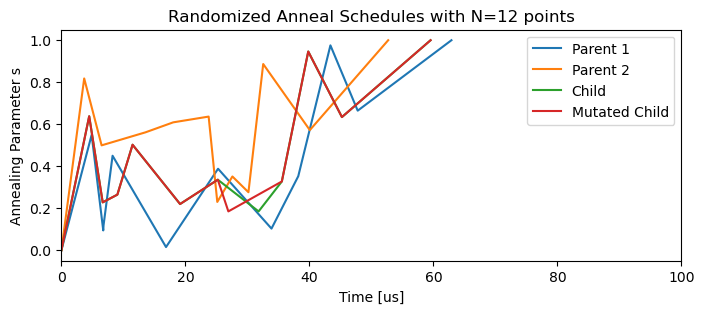

In [36]:
#test the breeding of two individuals and the mutation
#1) create two random individuals to breed
ind1 = create_random_schedule(npt, version='v3')
ind2 = create_random_schedule(npt, version='v3')
#breed them - obtain the child
child = breeding(ind1, ind2)
#mutate the child
child2 = mutation(child, 1)
print("Is the resulting mutated child a valid anneal? {}".format(check_anneal_schedule_slopes(child2)))
plot_population([ind1, ind2, child, child2], ['Parent 1','Parent 2','Child', 'Mutated Child'])

# The Genetic algorithm itself

Initialization

In [87]:
#make initial population of anneal_schedules
population = []
#add the basic linear schedule by default
population.append(basic_schedule)
#add version 1 - huge jumps (uniform from all)
for j in range(10):
    population.append(create_random_schedule(npt, version='v1'))
#add version 2 - more regularly spaced time slices
#for j in range(5):
#    population.append(create_random_schedule(npt, version='v2'))
population = np.array(population)
#define the genetic algorithm terms
Npop = len(population)
N_elite = 1 #keep one elite as well as the linear benchmark, at all times.
mutation_rate = [0.3, 0.1] #[no. of times an individual is chosen to mutation, variance of mutation]


Plot the initial population

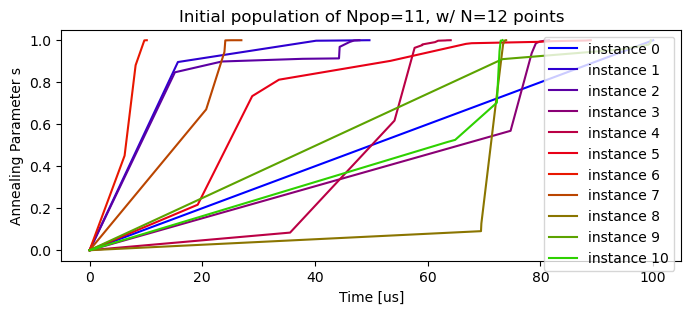

In [88]:
#plot the initial population
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Initial population of Npop={}, w/ N={} points".format(Npop, npt+2))
for j in range(len(population)):
    schedule = population[j]
    color = cm.brg(j/len(population)) # Choose a color based on position in the range [0, 1]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], \
        [schedule[i][1] for i in range(len(schedule))], label=plot_label, c=color)
plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

Proceed with the iterations.

**Caution** - The following cell can take a lot of time out of your free D-Wave access! There is a stop at 10 seconds of Leap access. But more would be needed to really have a strong result.

In [41]:
iteration = 1
maxiter = 20
n_reads = 20
kept_fidelity = np.zeros((maxiter, Npop))
kept_best_state = np.zeros((maxiter, len(h)))
kept_best_anneal = np.zeros((maxiter, npt+2))
total_time_used = 0
#initial fidelity
all_ene, fidelity, all_configs, timing = evaluate_function(population, num_reads = n_reads)
#fidelity is already declared above
total_time_used += timing

while iteration < maxiter:
    population = new_population(population, fidelity, N_elite, mutation_rate)
    all_ene, fidelity, all_config, timing = evaluate_function(population, h, J, num_reads = n_reads)
    total_time_used += timing
    kept_fidelity[iteration] = np.sort(fidelity)
    kept_best_state[iteration] = all_config[np.argmin(fidelity)]
    kept_best_anneal[iteration] = population[np.argmin(fidelity)]
    print("done w/ iteration {}, best fidelity = {}".format(iteration,np.min(fidelity)))
    print("total calls to the D-Wave sampler:{}".format(iteration*Npop*10))
    print("QPU time used {}".format(total_time_used))
    iteration += 1
    if total_time_used > 10:
        break

done w/ iteration 1, best fidelity = -3556.0
total calls to the D-Wave sampler:110
QPU time used 0.60200922
done w/ iteration 2, best fidelity = -3558.0
total calls to the D-Wave sampler:220
QPU time used 0.98319943
done w/ iteration 3, best fidelity = -3562.0
total calls to the D-Wave sampler:330
QPU time used 1.36696364
done w/ iteration 4, best fidelity = -3554.0
total calls to the D-Wave sampler:440
QPU time used 1.74909985
done w/ iteration 5, best fidelity = -3552.0
total calls to the D-Wave sampler:550
QPU time used 2.13243606
done w/ iteration 6, best fidelity = -3556.0
total calls to the D-Wave sampler:660
QPU time used 2.51954727
done w/ iteration 7, best fidelity = -3558.0
total calls to the D-Wave sampler:770
QPU time used 2.9088874799999997
done w/ iteration 8, best fidelity = -3554.0
total calls to the D-Wave sampler:880
QPU time used 3.3002396899999997
done w/ iteration 9, best fidelity = -3554.0
total calls to the D-Wave sampler:990
QPU time used 3.6917508999999997
done

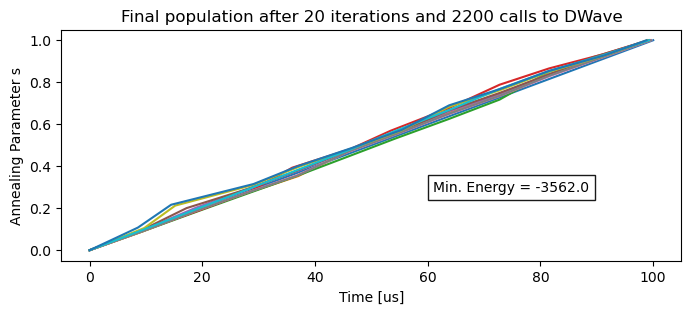

In [42]:
#plotting the final results

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Final population after {} iterations and {} calls to DWave".format(iteration, iteration*Npop*10))
for j in range(len(population)):
    schedule = population[j]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
#plt.legend()
ax.text(0.6, 0.3, 'Min. Energy = {}'.format(np.min(kept_fidelity)), bbox=dict(facecolor='white', alpha=0.9), transform=ax.transAxes)
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [51]:
#which schedule was the best?
for i in range(20):
    print('it:{}, F_min={} at index {}'.format(i,np.min(kept_fidelity[i]), np.argmin(kept_fidelity[i])))

it:0, F_min=0.0 at index 0
it:1, F_min=-3556.0 at index 0
it:2, F_min=-3558.0 at index 0
it:3, F_min=-3562.0 at index 0
it:4, F_min=-3554.0 at index 0
it:5, F_min=-3552.0 at index 0
it:6, F_min=-3556.0 at index 0
it:7, F_min=-3558.0 at index 0
it:8, F_min=-3554.0 at index 0
it:9, F_min=-3554.0 at index 0
it:10, F_min=-3556.0 at index 0
it:11, F_min=-3554.0 at index 0
it:12, F_min=-3556.0 at index 0
it:13, F_min=-3556.0 at index 0
it:14, F_min=-3554.0 at index 0
it:15, F_min=-3554.0 at index 0
it:16, F_min=-3556.0 at index 0
it:17, F_min=-3556.0 at index 0
it:18, F_min=-3560.0 at index 0
it:19, F_min=-3560.0 at index 0


Indeed, it looks like the best solution for this problem set (a very strange spin glass I think) is obtained with the straightforward anneal schedule.

It appears like the 0-th schedule (the linear benchmark) was the best schedule for this setup.

# Benchmarking this approach on a simple problem

We can use a simple problem of 16 qubits to see whether this approach can learn that an anneal with a long pause close to the freezout point is beneficial. A lot of insight of this section comes from the D-Wave Leap Example "Anneal Schedule". 

We use the 16-qubit system shown below, which was studied in https://www.nature.com/articles/ncomms2920, and has an energy gap of 4 between the classical ground state and excited states. The classical ground state has an energy of $E_{gs} = -20$.

This system is set up as shown in the image below, where dots are qubits with colors representing bias values and lines representing couplings (couplings weights are $-1$).
 
<img src='images/16q_system.png'>

The structure of this problem maps neatly to the Chimera topology of a D-Wave 2000Q QPU: it can be minor-embedded directly into two side-by-side Chimera unit cells, with each problem qubit represented by one qubit on the QPU.

In [91]:
#problem definition
h_s = {0: 1.0, 1: -1.0, 2: -1.0, 3: 1.0, 4: 1.0, 5: -1.0, 6: 0.0, 7: 1.0,
     8: 1.0, 9: -1.0, 10: -1.0, 11: 1.0, 12: 1.0, 13: 0.0, 14: -1.0, 15: 1.0}
J_s = {(9, 13): -1, (2, 6): -1, (8, 13): -1, (9, 14): -1, (9, 15): -1,
     (10, 13): -1, (5, 13): -1, (10, 12): -1, (1, 5): -1, (10, 14): -1,
     (0, 5): -1, (1, 6): -1, (3, 6): -1, (1, 7): -1, (11, 14): -1,
     (2, 5): -1, (2, 4): -1, (6, 14): -1}
#tiling it on Chimera
from dwave.system import TilingComposite, FixedEmbeddingComposite

tiled_sampler = TilingComposite(sampler, 1, 2, 4)

if tiled_sampler.num_tiles:
    sampler_embedded = FixedEmbeddingComposite(sampler, embedding=tiled_sampler.embeddings[0])
else:
    print("Unable to find two complete unit cells in QPU {}".format(sampler.solver.name))

Let's run the problem on a simple forward anneal, with the basic schedule:

In [92]:
num_reads=1000
results = sampler_embedded.sample_ising(h_s, J_s, 
    num_reads=num_reads,
    answer_mode='raw',
    num_spin_reversal_transforms=5,
    label='Notebook - Anneal Schedule',
    anneal_schedule = basic_schedule)

print("QPU time used:", results.info['timing']['qpu_access_time']/10**6, " seconds.")

QPU time used: 0.52454775  seconds.


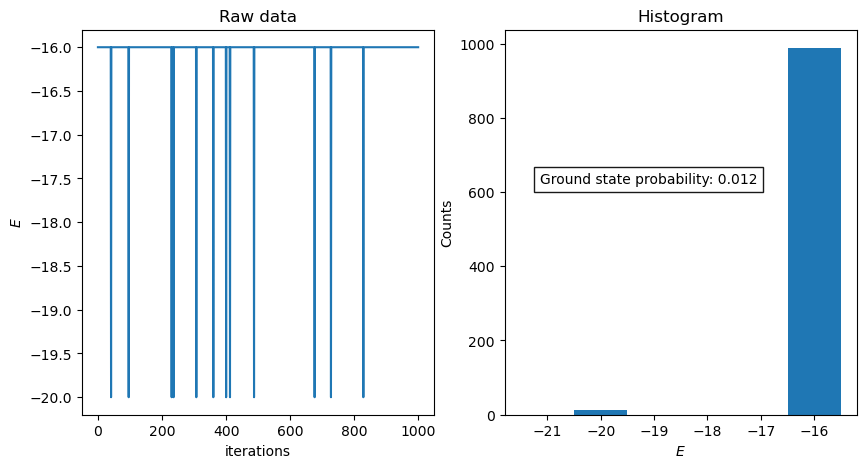

In [104]:
#plot the raw results obtained:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))


ax1.plot(results.record.energy)
ax1.set_xlabel('iterations')
ax1.set_ylabel(r'$E$')
ax1.set_title('Raw data')

ax2.hist(results.record.energy,rwidth=1,align='left',bins=[-21,-20,-19,-18,-17,-16,-15])
ax2.set_ylabel('Counts')
ax2.set_xlabel(r'$E$')
ax2.set_title('Histogram')
_, counts = np.unique(results.record.energy.reshape(num_reads,1), axis=0, return_counts=True)
#print("Ground state probability: ", counts[0]/num_reads)
ax2.text(0.1, 0.6, "Ground state probability: {}".format(counts[0]/num_reads), bbox=dict(facecolor='white', alpha=0.9), transform=ax2.transAxes)

plt.show()

Now our goal is to find a schedule that leads to a higher probablility!

A big difference from above is that the fidelity is calculated differently. Here, it will be $F = 20 + <E>$ for a given anneal. This will be minimized if the anneal leads to more instances of obtaining the ground state value.

We will also store the data in a pandas dataframe for easier access.

In [107]:
#make random initial population of anneal_schedules
population = []
#add the basic linear schedule by default
population.append(basic_schedule)
#add version 1 - huge jumps (uniform from all)
for j in range(10):
    population.append(create_random_schedule(npt, version='v1'))
#add version 2 - more regularly spaced time slices
#for j in range(5):
#    population.append(create_random_schedule(npt, version='v2'))
population = np.array(population)
#define the genetic algorithm terms
Npop = len(population)
N_elite = 1 #keep one elite as well as the linear benchmark, at all times.
mutation_rate = [0.5, 0.2] #[no. of times an individual is chosen to mutation, variance of mutation]


plot initial population

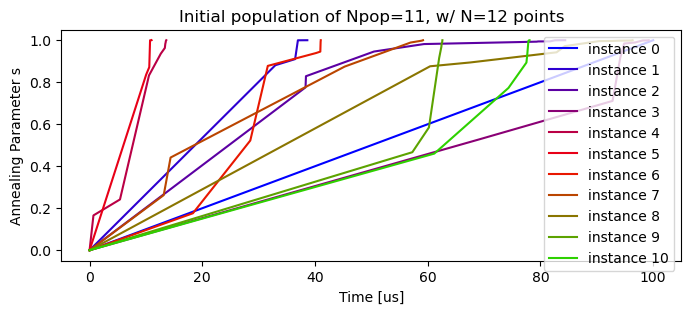

In [108]:
#plot the initial population
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Initial population of Npop={}, w/ N={} points".format(Npop, npt+2))
for j in range(len(population)):
    schedule = population[j]
    color = cm.brg(j/len(population)) # Choose a color based on position in the range [0, 1]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], \
        [schedule[i][1] for i in range(len(schedule))], label=plot_label, c=color)
plt.legend()
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

In [112]:

print("Starting QPU calls and Genetic optimization...")

iteration = 0
maxiter = 10
n_reads = 20
Egs = -20

schedule_and_fidelities = pd.DataFrame(index=range(maxiter),
                                columns=["anneal_schedules", "fidelities", "energies"],
                                data=None)

total_time_used = 0
#initial fidelity
all_ene, best_ene, all_configs, timing = evaluate_function(population,h_s, J_s, num_reads = n_reads)
fidelity = np.zeros(Npop)
for k in range(Npop):
    #we have currently a minimizer, but we want to maximize the GS count
    #hence the 1-x
    fidelity[k] = 1 - np.count_nonzero(all_ene[k] == Egs)/n_reads
#fidelity is already declared above
total_time_used += timing
iteration += 1
#update pd
schedule_and_fidelities.iloc[iteration]={"anneal_schedules":population,  
                            "fidelities":fidelity, "energies":all_ene}

while iteration < maxiter:
    population = new_population(population, fidelity, N_elite, mutation_rate)
    all_ene, best_ene, all_config, timing = evaluate_function(population, h_s, J_s, num_reads = n_reads)    
    #update the fidelity
    for k in range(Npop):
        #we have currently a minimizer, but we want to maximize the GS count
        #hence the 1-x
        fidelity[k] = 1 - np.count_nonzero(all_ene[k] == Egs)/n_reads

    schedule_and_fidelities.iloc[iteration]={"anneal_schedules":population,  
                                "fidelities":fidelity,
                                "energies":all_ene}
 
    total_time_used += timing
    print("done w/ iteration {}, best G.S. count = {}".format(iteration, 1 - np.min(fidelity)))
    print("total calls to the D-Wave sampler:{}".format(iteration*Npop*n_reads))
    print("QPU time used {}".format(total_time_used))
    iteration += 1
    if total_time_used > 10:
        break

Starting QPU calls and Genetic optimization...
done w/ iteration 1, best G.S. count = 0.050000000000000044
total calls to the D-Wave sampler:220
QPU time used 0.43738682000000007
done w/ iteration 2, best G.S. count = 0.050000000000000044
total calls to the D-Wave sampler:440
QPU time used 0.6601198300000001
done w/ iteration 3, best G.S. count = 0.050000000000000044
total calls to the D-Wave sampler:660
QPU time used 0.8829660400000001
done w/ iteration 4, best G.S. count = 0.050000000000000044
total calls to the D-Wave sampler:880
QPU time used 1.1058260500000001


KeyboardInterrupt: 

Evidently, not enough num_reads to do any optimization (the statistics of the fidelity for a given schedule is very poor!)

Given enough D-Wave access, this would likely converge to some anneal(slow)-pause-anneal(fast) protocol. To be tested!

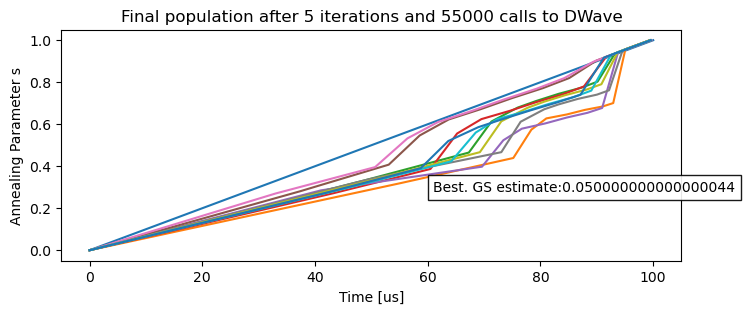

In [121]:
#plotting the final results
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Final population after {} iterations and {} calls to DWave".format(iteration, iteration*Npop*num_reads))
for j in range(len(population)):
    schedule = population[j]
    plot_label = 'instance {}'.format(j)
    ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))], label=plot_label)
#plt.legend()
ax.text(0.6, 0.3, 'Best. GS estimate:{}'.format(1 - np.min(fidelity)), bbox=dict(facecolor='white', alpha=0.9), transform=ax.transAxes)
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()

# Example

For code construction purposes: an anneal of the random problem with a random schedule.

In [81]:
#example of 10 reads with a random schedule
answer = sampler.sample_ising(h, J, 
                                      num_reads=100, 
                                      anneal_schedule=create_random_schedule(npt, version='v1'), 
                                      label='AS - random',
                                      answer_mode='raw')
#benchmark_solutions, benchmark_energies = forward_solutions, forward_energies
print("QPU time used:", answer.info['timing']['qpu_access_time']/10**6, " seconds.")
print("lowest energy = {}".format(np.min(answer.record.energy)))

QPU time used: 0.016855909999999998  seconds.
lowest energy = -3580.0


In [4]:
#example of 10 reads with a random schedule
answer = sampler.sample_ising(h, J, 
                                      num_reads=100, 
                                      anneal_schedule=[[0,0], [20, 0.7], [40, 0.3], [80, 0.3], [100, 1.0]], 
                                      label='AS - random',
                                      answer_mode='raw')
#benchmark_solutions, benchmark_energies = forward_solutions, forward_energies
print("QPU time used:", answer.info['timing']['qpu_access_time']/10**6, " seconds.")
print("lowest energy = {}".format(np.min(answer.record.energy)))

QPU time used: 0.058998709999999996  seconds.
lowest energy = -3388.1999999999953


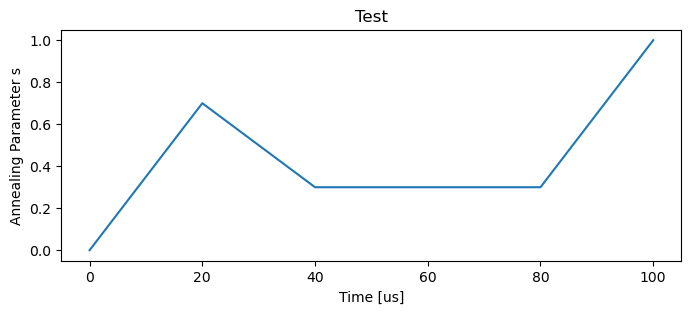

In [5]:
#plot it
schedule = [[0,0], [20, 0.7], [40, 0.3], [80, 0.3], [100, 1.0]]
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.set_title("Test")
ax.plot([schedule[i][0] for i in range(len(schedule))], [schedule[i][1] for i in range(len(schedule))])
plt.xlabel('Time [us]')
plt.ylabel('Annealing Parameter s')
plt.show()